# Demand Forecast for 7 days Horizon ZIPJET

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

C:\Users\navid\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


* Loading demand & supply Data sets

In [2]:
df_demand=(pd.read_csv('data/demand.csv')).sort_values(by=['day'])
df_supply=pd.read_csv('data/supply.csv')

* Some Pre-Processing

In [3]:
df_supply['calculated_datetime_date']=(pd.to_datetime(df_supply['calculated_datetime'])).dt.date
df_supply['calculated_datetime_date']=pd.to_datetime(df_supply['calculated_datetime_date'])
df_supply['day']=pd.to_datetime(df_supply['day'])

* Filtering supply data for just considering thoses time slots where the __avail_area_ratio__ was not zero
* Adding __cal_time_diff__ feature as it shows the diffrence beetween __Day__ and __Calculated_datetime__

In [4]:
df_supply_noZero=df_supply[df_supply.avail_area_ratio!=0]
df_supply_noZero['cal_time_diff']=df_supply_noZero['day']-df_supply_noZero['calculated_datetime_date']
df_supply_noZero['cal_time_diff']=df_supply_noZero['cal_time_diff'].dt.days

C:\Users\navid\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\navid\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* Engineering features for supply dataset by:
    * counting availbe slots per day for each grid_unit and shift
    * Average availbe area ratio per day for each grid_unit and shift
    * Average diffrence time between Day and Calculated_datetime (cal_time_diff)

In [5]:
df_supply_noZero=df_supply_noZero.groupby(['day','grid_unit']).agg({'timeslot_from':"nunique",'avail_area_ratio':"mean",'cal_time_diff':"mean",})

* After enginerring the features. I took average of all features per __DAY__

In [6]:
df_supply_noZero=df_supply_noZero.groupby(['day']).mean()
df_supply_noZero=df_supply_noZero.reset_index()
df_supply_noZero['day']=df_supply_noZero['day'].astype('str')

* Aggreaging Morning and Evening shifts' demand 

In [7]:
df_demand=df_demand.groupby('day').sum()

* Merging demand & supply data

In [8]:
final_data=pd.merge(df_supply_noZero,df_demand,how='left',on=['day'])

* Adding Day of Week & Day of Month as features

In [9]:
final_data['day']=pd.to_datetime(final_data['day'])
final_data['weekday']=final_data['day'].dt.weekday
final_data['monthday']=final_data['day'].dt.day

* Assigning date as index and also dropping NA raws

In [10]:
final_data.index=final_data['day']
final_data=final_data.drop(['day'],axis=1)
final_data=final_data.dropna()

* Cheking if the demand data is Stationary or not. ( it is stationary)

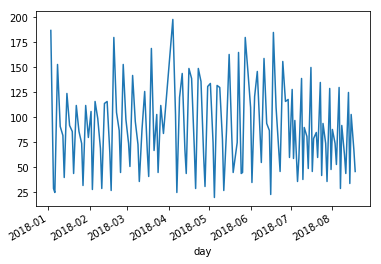

In [11]:
final_data.num_pickups.plot()

# Training Forecast Model by Encoder-Decoder LSTM

* split dataset into train/test sets

In [12]:
def split_dataset(data,hor=7):
    # split into standard weeks
    train, test = data.loc[:'2018-07-09'], data.loc['2018-07-10':]
    # restructure into windows of weekly data
    train = np.array(np.split(train.values, round(len(train)/hor)))
    test = np.array(np.split(test.values, round(len(test)/hor)))
    return train, test

* In order to splite whole data to standard week, I have to drop the first and last raw of the data
* Splitting the data into train and test.(data from 2018-07-10 is considered as test dataset)

In [13]:
final_data=final_data.drop(final_data.index[0])
final_data=final_data.drop(final_data.index[-1])
final_data=final_data[['num_pickups','timeslot_from', 'avail_area_ratio', 'cal_time_diff','weekday','monthday']]

In [14]:
train,test=split_dataset(final_data)

* For evaluating Model based on test dataset, __evaluate_forecasts__, __evaluate_model__ and __summarize_scores__ are developed.
* __RMSE__ will be used as metric for evaluation
* Moreover, __Walk-Forward__ validation over each week will be used as evaluation method

In [15]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [16]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores,model

In [17]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

* Below is a function takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [18]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

* Defining a function for forecasting. it take a trained model, history that we want to used for forecasting and the number of time step(n_input)

In [19]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

* Defining function for training a forecasting model by LSTM

In [27]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(300, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(300, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

* Now we have everything ready for training and evaluating forecast model

lstm: [41.246] 60.3, 44.6, 30.0, 42.8, 29.7, 17.3, 48.6


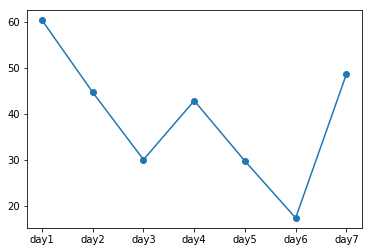

In [29]:
# evaluate model and get scores
n_input = 7
score, scores,model = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = [ 'day1', 'day2', 'day3', 'day4', 'day5', 'day6','day7']
plt.plot(days, scores, marker='o', label='lstm')
plt.show()

<div class="alert alert-block alert-success">
The plot shows that perhaps __day6__ and __day3__ are __easier__ days to forecast than the other days and __day1__ is the __hardest__ day to forecast.
</div>

====================================================================================================================

In [33]:
pd.DataFrame(forecast(model,test,7),columns=['Demand_Forecast'],index=[ 'day1', 'day2', 'day3', 'day4', 'day5', 'day6','day7'])

,Demand_Forecast
day1,97.681358
day2,45.420822
day3,100.223221
day4,98.041649
day5,88.589928
day6,61.286819
day7,105.499733
